In [1]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [3]:
class A:
    def __init__(self):
        self.b = 1

a = A()

In [4]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [5]:
class HyperParameters: #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [2]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

class B(d2l.HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [3]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

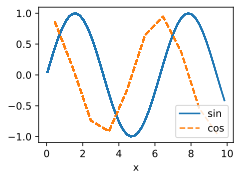

In [4]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

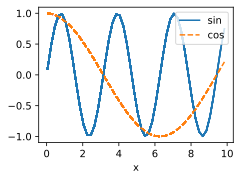

In [7]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(2*x), 'sin', every_n=2)
    board.draw(x, np.cos(x/2), 'cos', every_n=2)

In [9]:
class Module(nn.Module, d2l.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [10]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [11]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError